## Preprocess data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, median, variance, stdev
from fractions import Fraction
import re

### Useful functions

In [2]:

# Gets modifier value for each stat
def getModifier(stat, baseModifier=-5, startingStat=1, highestStat=30):
    modifier = baseModifier
    # if stat is equal to the base value return base modifier
    if stat == startingStat: return modifier

    # increment modifier by 1
    modifier += 1
    # Loop through all possible stat values and return the corresponding modifier value
    for i in range(2, highestStat):
        # if stat is between these values return the related modifier
        if stat >= i and stat <= i + 1: return modifier
        if not i % 2 == 1: modifier += 1
    return modifier

def convertToFloat(val):
    if type(val) == str:
        return float(Fraction(val))
    else:
        return float(val)

In [3]:
# Get data
dfWin = pd.read_csv("./DataFrames/Winners.csv", index_col=0)
dfLose = pd.read_csv("./DataFrames/Losers.csv", index_col=0)
dfWin.head()

,name,desc,cr,immunities,resists,conditions,wins,actions,hp,str,dex,con,int,wis,cha,ac,spd
0,Wraith of Ogre Power,Medium Undead Neutral Evil,5,"Necrotic,Poison,Charmed,Exhaustion,Grappled,Pa...","Acid,Cold,Fire,Lightning,Thunder,Bludgeoning,P...",Gauntlets of Ogre Power,"Werebear, Air Elemental, Troll, Roper, CR 5","Life Drain: +11, 4d8+9 Necrotic & Life Drain",39,19,16,16,12,14,15,13,60
1,Oni,Large Giant Lawful Evil,7,NaN,NaN,"Death Defying,Regeneration",NaN,"Glaive: +6, 10ft, 2d10+4 Slashing\tMultiattack...",55,19,11,16,14,12,15,16,30
2,Giant Ape,Huge Beast Unaligned,7,NaN,NaN,Shielded,NaN,"Fist: +8, 10ft, 3d10+6 Bludgeoning\tRock: +8, ...",69,23,14,18,7,12,7,12,40
3,Young Brass Dragon,Large Dragon Chaotic Good,6,Fire,NaN,Reliable Damage,NaN,"Multiattack: 10ft, Bite, 2 Claw\tBite: +6, 10f...",61,19,10,17,12,11,15,17,80
4,Fire Elemental,Large Elemental Neutral,5,"Fire,Poison,Exhaustion,Grappled,Paralyzed,Petr...","Bludgeoning,Piercing,Slashing","+2 CHA,Heated Body",NaN,"Touch: +5, 2d6+3 Fire, On Fire\tMultiattack: F...",46,10,17,16,6,10,9,13,50


### Find Win Rate of creatures

In [4]:
# Get data
dfWin = pd.read_csv("./DataFrames/Winners.csv", index_col=0)
dfLose = pd.read_csv("./DataFrames/Losers.csv", index_col=0)
dfWin.head()

cretName1 = 'Aboleth'
cretName2 = 'Chain Devil'

def getWinRate(cretName):
    cretWin = dfWin[dfWin['name'] == cretName]
    cretLost = dfLose[dfLose['name'] == cretName]
    return cretWin.shape[0]/cretLost.shape[0]




print(f"{cretName1} Win Rate: {getWinRate(cretName1)}")
print(f"{cretName2} Win Rate: {getWinRate(cretName2)}")

wins = losses = 0

for (index, rWin), (_, rLose) in zip(dfWin.iterrows(), dfLose.iterrows()):
        if rWin['name'] == cretName1 and rLose['name'] == cretName2:
            wins += 1
        if rLose['name'] == cretName1 and rWin['name'] == cretName2:
            losses += 1

print(f"{cretName1} won {wins} out of {wins + losses} matches")


Aboleth Win Rate: 0.5294117647058824
Chain Devil Win Rate: 1.1176470588235294
Aboleth won 1 out of 3 matches


#### Compare data distribution

Mean: 3.952508162659543
 Median: 3.0
StdDev: 19.484459816797333


[]

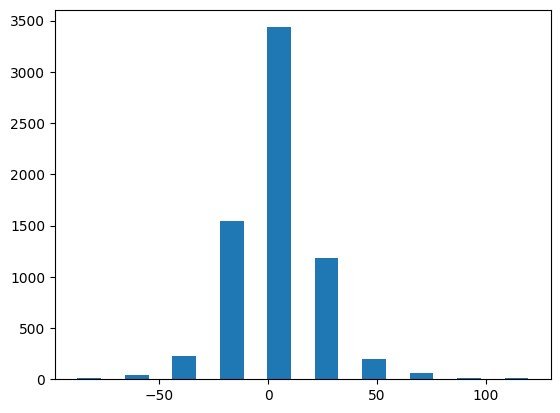

In [7]:
def convertCRToFloat(row):
    return convertToFloat(row)

def getLength(row: str):
    if row != row:
        return 0
    vals = row.split(',')
    return len(vals)

dfWin['cr'] = dfWin.apply(lambda row: convertCRToFloat(row['cr']), axis=1)
dfLose['cr'] = dfLose.apply(lambda row: convertCRToFloat(row['cr']), axis=1)
# Due to an error in cr a few data points have 



dfWin['winlen'] = dfWin.apply(lambda row: getLength(row['wins']), axis=1)
dfLose['winlen'] = dfLose.apply(lambda row: getLength(row['wins']), axis=1)


def getDifData(df1: pd.DataFrame, df2: pd.DataFrame, targets: list, stats=['ac', 'cr', 'spd', 'hp', 'str', 'dex', 'con', 'int', 'wis', 'cha']):
    vals = np.zeros(df1.shape[0], len(stats))
    for (i, r1), (_, r2) in zip(df1.iterrows(), df2.iterrows()):
        for j, stat in enumerate(stats):
            # If a stat is greater than a believable amount make the stat equal to its opponent
            # This allows for better generalization of the data
            if r1[stat] >= 900: r1[stat] = r2[stat]
            if r2[stat] >= 900: r2[stat] = r1[stat]
            vals[i, j] = r1[stat] - r2[stat] if targets[i] else r2[stat] - r1[stat]
    return vals


def findDifference(dfWin: pd.DataFrame, dfLose: pd.DataFrame, stat):
    for (index, rWin), (_, rLose) in zip(dfWin.iterrows(), dfLose.iterrows()):
        # If a stat is greater than a believable amount make the stat equal to its opponent
        # This allows for better generalization of the data
        if rWin[stat] >= 900: rWin[stat] = rLose[stat]
        if rLose[stat] >= 900: rLose[stat] = rWin[stat]
        # Return list of all stats
        dif = rWin[stat] - rLose[stat]

        yield dif



dif = list(findDifference(dfWin, dfLose, 'hp'))



print(f"Mean: {mean(dif)}\n Median: {median(dif)}\nStdDev: {stdev(dif)}")
plt.hist(dif, rwidth=0.5)
plt.plot()

[]

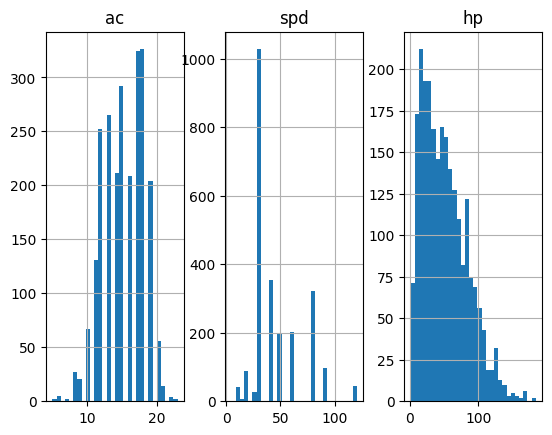

In [155]:
# Compare HP
fig, axes = plt.subplots(1,3)
dfWin.hist(['ac', 'spd', 'hp'], bins=30, ax=axes)
plt.plot()

[]

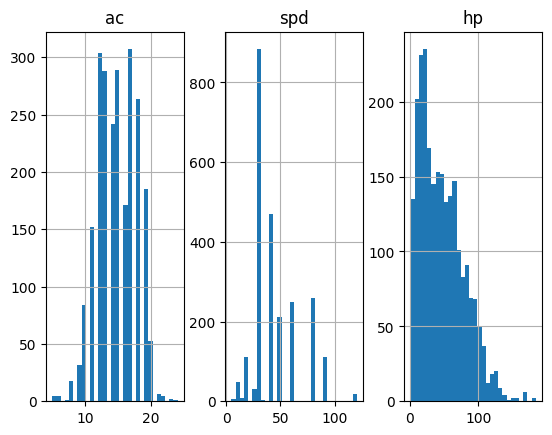

In [156]:
fig, axes = plt.subplots(1,3)
dfLose.hist(['ac', 'spd', 'hp'], bins=30, ax=axes)
plt.plot()

In [24]:
# Code to extract expected damage value per turn of each creature
# TODO: Finish code and refine regex
row = dfWin.loc[0]['actions']
print(row)



def getActions(row):
    # Get regex patterns
    
    # Action name
    patName = ':' 
    patMod = r'(\d+),'
    patVals = r'(\d+)(d)(\d+)(\+)(\d+)|(\d+)(d)(\d+)'
    patEffects = r'(Slashing|Piercing|Bludgeoning|Poison|Acid|Fire|Cold|Radiant|Necrotic|Lightning|Thunder|Force|Psychic)'
    patConds = r'(Blinded|Charmed|Deafened|Frightened|Grappled|Incapacitated|Invisible|Paralyzed|Petrified|Poisoned|Prone|Psychic|Restrained|Stunned|Unconscious|Exhaustion)'

    # Seperate all actions into seperate values
    actions = row.split('\t')

    return actions



allActions = dfWin.apply(lambda row: getActions(row["actions"]), axis=1)

print(allActions.to_numpy())

Life Drain: +11, 4d8+9 Necrotic & Life Drain
[list(['Life Drain: +11, 4d8+9 Necrotic & Life Drain'])
 list(['Glaive: +6, 10ft, 2d10+4 Slashing', 'Multiattack: 10ft, 2 Glaive', 'Charm Person: 30ft, Charmed (WIS Save) (If Humanoid)', 'Sleep: 90ft, Asleep (WIS Save)', 'Cone of Cold: 60ft, 8d8 Cold (CON Save)'])
 list(['Fist: +8, 10ft, 3d10+6 Bludgeoning', 'Rock: +8, 50ft, 7d6+6 Bludgeoning', 'Multiattack: 10ft, 2 Fist', 'Shield: +5 to AC, Reaction'])
 ... list(['Bite: -1, 1d4+5 Piercing, Rat Bite Fever (CON Save)'])
 list(['Hooves: +2, 1d4+2 Bludgeoning'])
 list(['Bite: +5, 1d4+3 Piercing, Stirge Attached', 'Blood Drain: 1d4+3 Blood Loss (If Stirge Attached)'])]


In [43]:
for action in allActions:
    print(f"\n{action}")


['Life Drain: +11, 4d8+9 Necrotic & Life Drain']

['Glaive: +6, 10ft, 2d10+4 Slashing', 'Multiattack: 10ft, 2 Glaive', 'Charm Person: 30ft, Charmed (WIS Save) (If Humanoid)', 'Sleep: 90ft, Asleep (WIS Save)', 'Cone of Cold: 60ft, 8d8 Cold (CON Save)']

['Fist: +8, 10ft, 3d10+6 Bludgeoning', 'Rock: +8, 50ft, 7d6+6 Bludgeoning', 'Multiattack: 10ft, 2 Fist', 'Shield: +5 to AC, Reaction']

['Multiattack: 10ft, Bite, 2 Claw', 'Bite: +6, 10ft, 15 Piercing, 11 Piercing (If Crit)', 'Claw: +6, 11 Slashing, 7 Slashing (If Crit)', 'Breath Weapon: 40ft, 1x (Fire Breath, Sleep Breath)', 'Fire Breath: 40ft, 42 Fire (DEX Save)', 'Sleep Breath: 30ft, Asleep (CON Save)']

['Touch: +5, 2d6+3 Fire, On Fire', 'Multiattack: Fire Form, 2 Touch', 'Fire Form: 1d10 Fire, On Fire']

['Multiattack: Bite, 2 Longsword', 'Multishot: 150ft, 3 Longbow', 'Bite: +5, 1d4 Piercing, 2d8 Poison, The Plague (CON Save)', 'Longsword: +5, 1d10+3 Slashing', 'Longbow: +5, 150ft, 1d8+3 Piercing, 1d8 Poison', 'Faerie Fire: 60ft, 

In [83]:
# Class to store all creature attack information
# class CreatureAttackInfo:
#     def __init__(self, actions: str) -> None:
#         # split actions into there corresponding parts
#         ...

class Action:
    def __init__(self, name: str, actionString: str):
        # Initialize all action params
        self.name = name
        self.expDmg = []
        self.atkType = []
        # Process specifics of action
        self.processAction(actionString)
    
    # Get the expected amount of damage and its assosciated damage type
    def processAction(self, info: str):
        info = info.split(',')
        for inf in info:
            # If the inf val contains a damage type then that value must contain a damage value
            damType = re.findall(r'(Slashing|Piercing|Bludgeoning|Poison|Acid|Fire|Cold|Radiant|Necrotic|Lightning|Thunder|Force|Psychic)', inf)
            if damType:
                # Get all numbers in the action string
                nums = [int(word) for word in re.findall(r'\d+', inf)]
                self.expDmg.append(getExpectedDiceVal(nums))
                self.atkType.extend(damType)

class MultiAttack:
    def __init__(self, actionString: str):
        self.names = []
        self.amounts = []
        self.processMulti(actionString)
    
    def processMulti(self, info: str):
        for move in info.split(','):
            # Get the name of the attack
            print(move)
            self.names.extend(re.findall(r"\b[a-zA-Z]+", move))
            # Find the amount of times the attack is used
            amount = re.findall(r"\d+\b", move)
            if amount:
                self.amounts.extend(amount)
            else:
                self.amounts.append(1)


# actions = {"name": [], "modifier": [], "vals": [], "effects": [], "conditions": []}
actions = allActions[1001]
print(actions)
valsPat1 = r',\s*(-?\d+(?:\.\d+)?)\s*(?:\w+\s*)*,'
valsPat2 = r'(\d+)(d)(\d+)(\+)(\d+)|(\d+)(d)(\d+)'

# Gets the modifier for the attack string
def getModifier(info: str):
    modifier = re.findall(r':\s*(-?\+?\d+),', info)
    if modifier: 
        return int(modifier[0])
    return 0

# Method used to calculate the expected value of a dice for example 1d6 has an expected val of 3.5
def getExpectedDiceVal(attackVals: list):
    # If list is empty return 0
    if not attackVals: return 0
    # If the list only has one value return that val
    if len(attackVals) == 1: return attackVals[0]
    # Initialize expected value
    expectedVal = 0
    # Loop through all possible dice values and multiply each val with its corresponding probability of occurence
    for i in range(attackVals[1]):
        expectedVal += (i + 1) * (1/attackVals[1])
    expectedVal *= attackVals[0]
    # If there is a third number add that value to the expected value
    if len(attackVals) >= 3: expectedVal += attackVals[2]
    # Return expected value
    return round(expectedVal, 3)


def getActionInfo(actions: list):
    possibleActions = []
    for action in actions:
        split = action.split(':')
        name = split[0]
        actionInfo = split[1]
        if name == "Multiattack":
            attacks = processMulti(actionInfo)
            print(f"Multiattack: {attacks}")
            continue

        
        #print(getModifier(actionInfo))
        print(f"Name: {name} Attack type: {getAttackDmgAndType(actionInfo)}")
        # loop through all info of action
    

    # modifier = re.findall(r':\s*(-?\+?\d+),', action)
    # vals = re.findall(valsPat2, action)
    # effects = re.findall(r'(Slashing|Piercing|Bludgeoning|Poison|Acid|Fire|Cold|Radiant|Necrotic|Lightning|Thunder|Force|Psychic)', action)
    # conditions = re.findall(r'(Blinded|Charmed|Deafened|Frightened|Grappled|Incapacitated|Invisible|Paralyzed|Petrified|Poisoned|Prone|Psychic|Restrained|Stunned|Unconscious|Exhaustion|Asleep)', action)
    # print(f"Name: {name}, Modifier: {modifier}, Values: {vals}, Effects: {effects}, Conditions: {conditions}")
# Append all values
# actions["name"].append(name)
# actions["modifier"].append(modifier)
# actions["vals"].append(vals)
# actions["effects"].append(effects)
# actions["conditions"].append(conditions)


#print(name)

['Multiattack: 10ft, Frightful Presence, Bite, 2 Claw', 'Bite: +10, 10ft, 2d10+6 Piercing, 2d6 Poison', 'Claw: +10, 2d6+6 Slashing', 'Tail: +10, 15ft, 2d8+6 Bludgeoning', 'Frightful Presence: 120ft, Frightened (WIS Save)', 'Wing Attack: 2d6+6 Bludgeoning (DEX Save)', 'Poison Breath: 60ft, 16d6 Poison (CON Save)', 'Parry: +5 to AC vs 1 Attack, Reaction']
 10ft
 Frightful Presence
 Bite
 2 Claw
Multiattack: {'name': ['Frightful', 'Presence', 'Bite', 'Claw'], 'amount': [1, 1, 1, '2']}
Name: Bite Attack type: {'damage': [17.0, 7.0], 'type': ['Piercing', 'Poison']}
Name: Claw Attack type: {'damage': [13.0], 'type': ['Slashing']}
Name: Tail Attack type: {'damage': [15.0], 'type': ['Bludgeoning']}
Name: Frightful Presence Attack type: {'damage': [], 'type': []}
Name: Wing Attack Attack type: {'damage': [13.0], 'type': ['Bludgeoning']}
Name: Poison Breath Attack type: {'damage': [56.0], 'type': ['Poison']}
Name: Parry Attack type: {'damage': [], 'type': []}
